In [144]:
# HIDDEN
import matplotlib
matplotlib.use('Agg')
from datascience import *
%matplotlib inline
import matplotlib.pyplot as plots
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import scipy.stats as stats
plots.style.use('fivethirtyeight')

This section will discuss machine learning.  Machine learning is a class of techniques for automatically finding patterns in data and using it to draw inferences or make predictions.  We're going to focus on a particular kind of machine learning, namely, *classification*.

Classification is about learning how to make predictions from past examples: we're given some examples where we have been told what the correct prediction was, and we want to learn from those examples how to make good predictions in the future.  Here are a few applications where classification is used in practice:

- For each order Amazon receives, Amazon would like to predict: *is this order fraudulent?*  They have some information about each order (e.g., its total value, whether the order is being shipped to an address this customer has used before, whether the shipping address is the same as the credit card holder's billing address).  They have lots of data on past orders, and they know whether which of those past orders were fraudulent and which weren't.  They want to learn patterns that will help them predict, as new orders arrive, whether those new orders are fraudulent.

- Online dating sites would like to predict: *are these two people compatible?*  Will they hit it off?  They have lots of data on which matches they've suggested to their customers in the past, and they have some idea which ones were successful.  As new customers sign up, they'd like to predict make predictions about who might be a good match for them.

- Doctors would like to know: *does this patient have cancer?*  Based on the measurements from some lab test, they'd like to be able to predict whether the particular patient has cancer.  They have lots of data on past patients, including their lab measurements and whether they ultimately developed cancer, and from that, they'd like to try to infer what measurements tend to be characteristic of cancer (or non-cancer) so they can diagnose future patients accurately.

- Politicians would like to predict: *are you going to vote for them?*  This will help them focus fundraising efforts on people who are likely to support them, and focus get-out-the-vote efforts on voters who will vote for them.  Public databases and commercial databases have a lot of information about most people: e.g., whether they own a home or rent; whether they live in a rich neighborhood or poor neighborhood; their interests and hobbies; their shopping habits; and so on.  And political campaigns have surveyed some voters and found out who they plan to vote for, so they have some examples where the correct answer is known.  From this data, the campaigns would like to find patterns that will help them make predictions about all other potential voters.

All of these are classification tasks.  Notice that in each of these examples, the prediction is a yes/no question -- we call this *binary classification*, because there are only two possible predictions.  In a classification task, we have a bunch of *observations*.  Each observation represents a single individual or a single situation where we'd like to make a prediction.  Each observation has multiple *attributes*, which are known (e.g., the total value of the order; voter's annual salary; and so on).  Also, each observation has a *class*, which is the answer to the question we care about (e.g., yes or no; fraudulent or not; etc.).

For instance, with the Amazon example, each order corresponds to a single observation.  Each observation has several attributes (e.g., the total value of the order, whether the order is being shipped to an address this customer has used before, and so on).  The class of the observation is either 0 or 1, where 0 means that the order is not fraudulent and 1 means that the order is fraudulent.  Given the attributes of some new order, we are trying to predict its class.

Classification requires data.  It involves looking for patterns, and to find patterns, you need data.  That's where the data science comes in.  In particular, we're going to assume that we have access to *training data*: a bunch of observations, where we know the class of each observation.  The collection of these pre-classified observations is also called a training set.  A classification algorithm is going to analyze the training set, and then come up with a classifier: an algorithm for predicting the class of future observations.

Note that classifiers do not need to be perfect to be useful.  They can be useful even if their accuracy is less than 100%.  For instance, if the online dating site occasionally makes a bad recommendation, that's OK; their customers already expect to have to meet many people before they'll find someone they hit it off with.  Of course, you don't want the classifier to make too many errors -- but it doesn't have to get the right answer every single time.

### Chronic kidney disease

Let's work through an example.  We're going to work with a data set that was collected to help doctors diagnose chronic kidney disease (CKD).  Each row in the data set represents a single patient who was treated in the past and whose diagnosis is known.  For each patient, we have a bunch of measurements from a blood test.  We'd like to find which measurements are most useful for diagnosing CKD, and develop a way to classify future patients as "has CKD" or "doesn't have CKD" based on their blood test results.

Let's load the data set into a table and look at it.

In [145]:
ckd = Table.read_table('ckd.csv')
ckd

Age,Blood Pressure,Specific Gravity,Albumin,Sugar,Red Blood Cells,Pus Cell,Pus Cell clumps,Bacteria,Blood Glucose Random,Blood Urea,Serum Creatinine,Sodium,Potassium,Hemoglobin,Packed Cell Volume,White Blood Cell Count,Red Blood Cell Count,Hypertension,Diabetes Mellitus,Coronary Artery Disease,Appetite,Pedal Edema,Anemia,Class
48,70,1.005,4,0,normal,abnormal,present,notpresent,117,56,3.8,111,2.5,11.2,32,6700,3.9,yes,no,no,poor,yes,yes,1
53,90,1.02,2,0,abnormal,abnormal,present,notpresent,70,107,7.2,114,3.7,9.5,29,12100,3.7,yes,yes,no,poor,no,yes,1
63,70,1.01,3,0,abnormal,abnormal,present,notpresent,380,60,2.7,131,4.2,10.8,32,4500,3.8,yes,yes,no,poor,yes,no,1
68,80,1.01,3,2,normal,abnormal,present,present,157,90,4.1,130,6.4,5.6,16,11000,2.6,yes,yes,yes,poor,yes,no,1
61,80,1.015,2,0,abnormal,abnormal,notpresent,notpresent,173,148,3.9,135,5.2,7.7,24,9200,3.2,yes,yes,yes,poor,yes,yes,1
48,80,1.025,4,0,normal,abnormal,notpresent,notpresent,95,163,7.7,136,3.8,9.8,32,6900,3.4,yes,no,no,good,no,yes,1
69,70,1.01,3,4,normal,abnormal,notpresent,notpresent,264,87,2.7,130,4,12.5,37,9600,4.1,yes,yes,yes,good,yes,no,1
73,70,1.005,0,0,normal,normal,notpresent,notpresent,70,32,0.9,125,4,10,29,18900,3.5,yes,yes,no,good,yes,no,1
73,80,1.02,2,0,abnormal,abnormal,notpresent,notpresent,253,142,4.6,138,5.8,10.5,33,7200,4.3,yes,yes,yes,good,no,no,1
46,60,1.01,1,0,normal,normal,notpresent,notpresent,163,92,3.3,141,4,9.8,28,14600,3.2,yes,yes,no,good,no,no,1


We have data on 158 patients.  There are an awful lot of attributes here.  The column labelled "Class" indicates whether the patient was diagnosed with CKD: 1 means they have CKD, 0 means they do not have CKD.

Let's look at two columns in particular: the hemoglobin level (in the patient's blood), and the blood glucose level (at a random time in the day; without fasting specially for the blood test).  We'll draw a scatter plot, to make it easy to visualize this.  Red dots are patients with CKD; blue dots are patients without CKD.  What test results seem to indicate CKD?

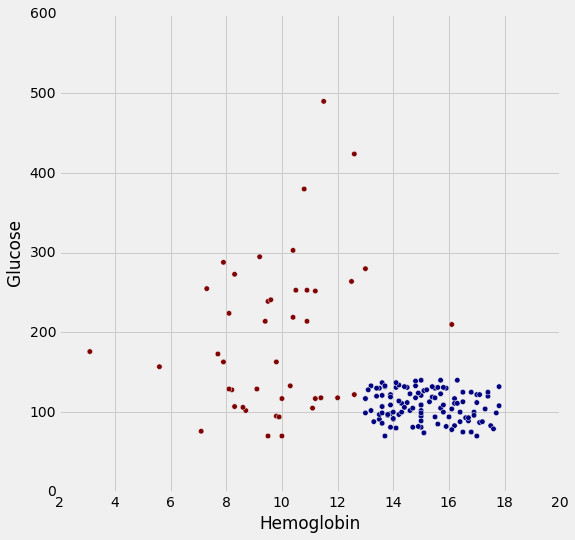

In [146]:
plots.figure(figsize=(8,8))
plots.scatter(ckd['Hemoglobin'], ckd['Blood Glucose Random'], c=ckd['Class'], s=30)
plots.xlabel('Hemoglobin')
plots.ylabel('Glucose')

Suppose Alice is a new patient who is not in the data set.  If I tell you Alice's hemoglobin level and blood glucose level, could you predict whether she has CKD?  It sure looks like it!  You can see a very clear pattern here: points in the lower-right tend to represent people who don't have CKD, and the rest tend to be folks with CKD.  To a human, the pattern is obvious.  But how can we program a computer to automatically detect patterns such as this one?

Well, there are lots of kinds of patterns one might look for, and lots of algorithms for classification.  But I'm going to tell you about one that turns out to be surprisingly effective.  It is called *nearest neighbor classification*.  Here's the idea.  If we have Alice's hemoglobin and glucose numbers, we can put her somewhere on this scatterplot; the hemoglobin is her x-coordinate, and the glucose is her y-coordinate.  Now, to predict whether she has CKD or not, we find the nearest point in the scatterplot and check whether it is red or blue; we predict that Alice should receive the same diagnosis as that patient.

In other words, to classify Alice as CKD or not, we find the patient in the training set who is "nearest" to Alice, and then use that patient's diagnosis as our prediction for Alice.  The intuition is that if two points are near each other in the scatterplot, then the corresponding measurements are pretty similar, so we might expect them to receive the same diagnosis (more likely than not).  We don't know Alice's diagnosis, but we do know the diagnosis of all the patients in the training set, so we find the patient in the training set who is most similar to Alice, and use that patient's diagnosis to predict Alice's diagnosis.

The scatterplot suggests that this *nearest neighbor classifier* should be pretty accurate.  Points in the lower-right will tend to receive a "no CKD" diagnosis, as their nearest neighbor will be a blue point.  The rest of the points will tend to receive a "CKD" diagnosis, as their nearest neighbor will be a red point.  So the nearest neighbor strategy seems to capture our intuition pretty well, for this example.

However, the separation between the two classes won't always be quite so clean.  For instance, suppose that instead of hemoglobin levels we were to look at white blood cell count.  Look at what happens:

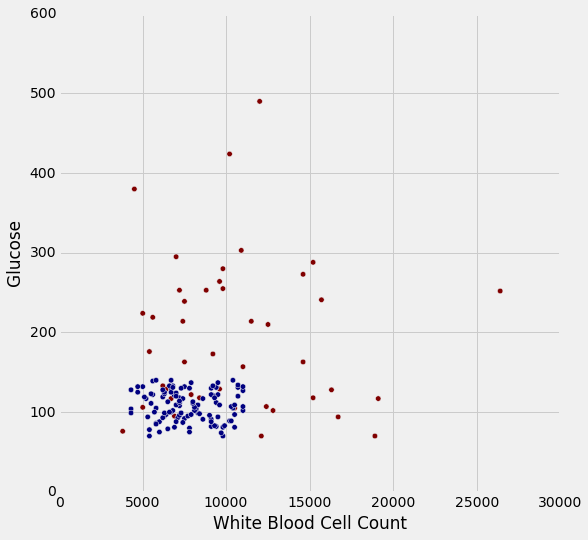

In [147]:
plots.figure(figsize=(8,8))
plots.scatter(ckd['White Blood Cell Count'], ckd['Blood Glucose Random'], c=ckd['Class'], s=30)
plots.xlabel('White Blood Cell Count')
plots.ylabel('Glucose')

As you can see, non-CKD individuals are all clustered in the lower-left.  Most of the patients with CKD are above or to the right of that cluster... but not all.  There are some patients with CKD who are in the lower left of the above figure (as indicated by the handful of red dots scattered among the blue cluster).  What this means is that you can't tell for certain whether someone has CKD from just these two blood test measurements.

If we are given Alice's glucose level and white blood cell count, can we predict whether she has CKD?  Yes, we can make a prediction, but we shouldn't expect it to be 100% accurate.  Intuitively, it seems like there's a natural strategy for predicting: plot where Alice lands in the scatter plot; if she is in the lower-left, predict that she doesn't have CKD, otherwise predict she has CKD.  This isn't perfect -- our predictions will sometimes be wrong.  (Take a minute and think it through: for which patients will it make a mistake?)  As the scatterplot above indicates, sometimes people with CKD have glucose and white blood cell levels that look identical to those of someone without CKD, so any classifier is inevitably going to make the wrong prediction for them.

Can we automate this on a computer?  Well, the nearest neighbor classifier would be a reasonable choice here too.  Take a minute and think it through: how will its predictions compare to those from the intuitive strategy above?  When will they differ?  Its predictions will be pretty similar to our intuitive strategy, but occasionally it will make a different prediction.  In particular, if Alice's blood test results happen to put her right near one of the red dots in the lower-left, the intuitive strategy would predict "not CKD", whereas the nearest neighbor classifier will predict "CKD".

There is a simple generalization of the nearest neighbor classifier that fixes this anomaly.  It is called the *k-nearest neighbor classifier*.  To predict Alice's diagnosis, rather than looking at just the one neighbor closest to her, we can look at the 3 points that are closest to her, and use the diagnosis for each of those 3 points to predict Alice's diagnosis.  In particular, we'll use the majority value among those 3 diagnoses as our prediction for Alice's diagnosis.  Of course, there's nothing special about the number 3: we could use 4, or 5, or more.  (It's often convenient to pick an odd number, so that we don't have to deal with ties.)  In general, we pick a number $k$, and our predicted diagnosis for Alice is based on the $k$ patients in the training set who are closest to Alice.  Intuitively, these are the $k$ patients whose blood test results were most similar to Alice, so it seems reasonable to use their diagnoses to predict Alice's diagnosis.

The $k$-nearest neighbor classifier will now behave just like our intuitive strategy above.

### Decision boundary

Sometimes a helpful way to visualize a classifier is to map the region of space where the classifier would predict 'CKD', and the region of space where it would predict 'not CKD'.  We end up with some boundary between the two, where points on one side of the boundary will be classified 'CKD' and points on the other side will be classified 'not CKD'.  This boundary is called the *decision boundary*.  Each different classifier will have a different decision boundary; the decision boundary is just a way to visualize what criteria the classifier is using to classify points.

### Banknote authentication

Let's do another example.  This time we'll look at predicting whether a banknote (e.g., a \$20 bill) is counterfeit or legitimate.  Researchers have put together a data set for us, based on photographs of many individual banknotes: some counterfeit, some legitimate.  They computed a few numbers from each image, using techniques that we won't worry about for this course.  So, for each banknote, we know a few numbers that were computed from a photograph of it as well as its class (whether it is counterfeit or not).  Let's load it into a table and take a look.

In [148]:
banknotes = Table.read_table('banknote.csv')
banknotes

WaveletVar,WaveletSkew,WaveletCurt,Entropy,Class
3.6216,8.6661,-2.8073,-0.44699,0
4.5459,8.1674,-2.4586,-1.4621,0
3.866,-2.6383,1.9242,0.10645,0
3.4566,9.5228,-4.0112,-3.5944,0
0.32924,-4.4552,4.5718,-0.9888,0
4.3684,9.6718,-3.9606,-3.1625,0
3.5912,3.0129,0.72888,0.56421,0
2.0922,-6.81,8.4636,-0.60216,0
3.2032,5.7588,-0.75345,-0.61251,0
1.5356,9.1772,-2.2718,-0.73535,0


Let's look at whether the first two numbers tell us anything about whether the banknote is counterfeit or not.  Here's a scatterplot:

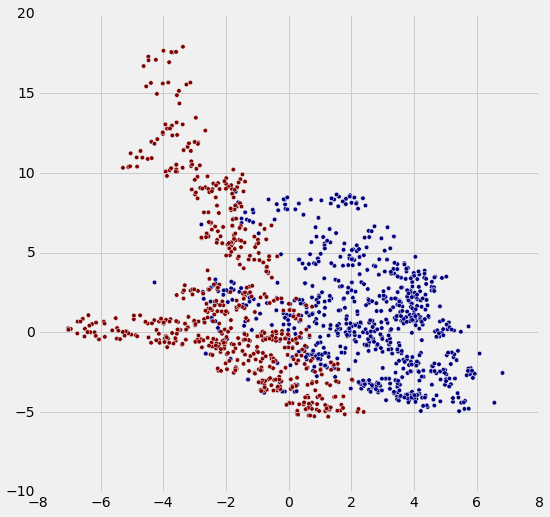

In [149]:
plots.figure(figsize=(8,8))
plots.scatter(banknotes['WaveletVar'], banknotes['WaveletCurt'], c=banknotes['Class'])

Pretty interesting!  Those two measurements do seem helpful for predicting whether the banknote is counterfeit or not.  However, in this example you can now see that there is some overlap between the blue cluster and the red cluster.  This indicates that there will be some images where it's hard to tell whether the banknote is legitimate based on just these two numbers.  Still, you could use a $k$-nearest neighbor classifier to predict the legitimacy of a banknote.

Take a minute and think it through: Suppose we used $k=11$ (say).  What parts of the plot would the classifier get right, and what parts would it make errors on?  What would the decision boundary look like?

The patterns that show up in the data can get pretty wild.  For instance, here's what we'd get if used a different pair of measurements from the images:

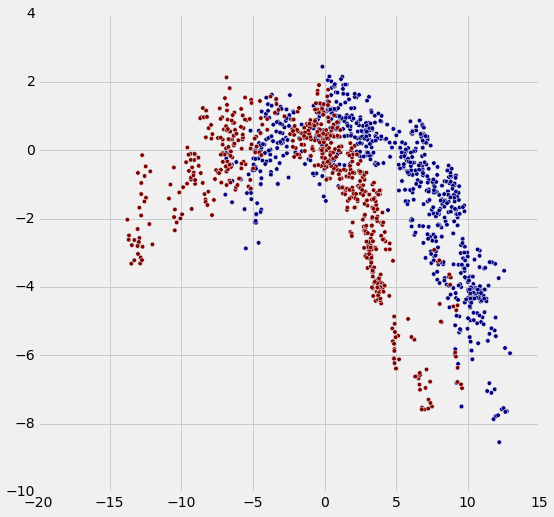

In [150]:
plots.figure(figsize=(8,8))
plots.scatter(banknotes['WaveletSkew'], banknotes['Entropy'], c=banknotes['Class'])

There does seem to be a pattern, but it's a pretty complex one.  Nonetheless, the $k$-nearest neighbors classifier can still be used and will effectively "discover" patterns out of this.  This illustrates how powerful machine learning can be: it can effectively take advantage of even patterns that we would not have anticipated, or that we would have thought to "program into" the computer.

### Multiple attributes

So far I've been assuming that we have exactly 2 attributes that we can use to help us make our prediction.  What if we have more than 2?  For instance, what if we have 3 attributes?

Here's the cool part: you can use the same ideas for this case, too.  All you have to do is make a 3-dimensional scatterplot, instead of a 2-dimensional plot.  You can still use the $k$-nearest neighbors classifier, but now computing distances in 3 dimensions instead of just 2.  It just works.  Very cool!

In fact, there's nothing special about 2 or 3.  If you have 4 attributes, you can use the $k$-nearest neighbors classifier in 4 dimensions.  5 attributes?  Work in 5-dimensional space.  And no need to stop there!  This all works for arbitrarily many attributes; you just work in a very high dimensional space.  It gets wicked-impossible to visualize, but that's OK.  The computer algorithm generalizes very nicely: all you need is the ability to compute the distance, and that's not hard.  Mind-blowing stuff!

For instance, let's see what happens if we try to predict whether a banknote is counterfeit or not using 3 of the measurements, instead of just 2.  Here's what you get:

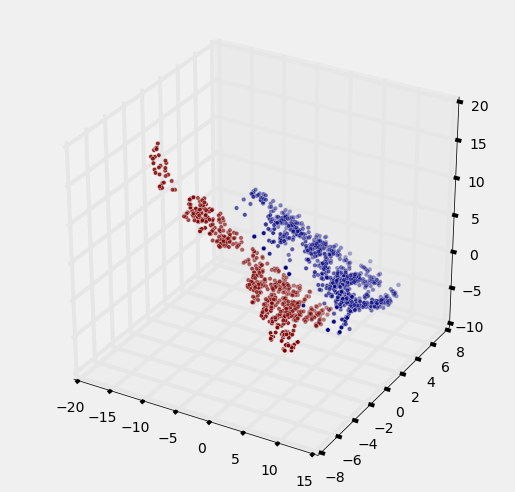

In [151]:
ax = plots.figure(figsize=(8,8)).add_subplot(111, projection='3d')
ax.scatter(banknotes['WaveletSkew'], banknotes['WaveletVar'], banknotes['WaveletCurt'], c=banknotes['Class'])

Awesome!  With just 2 attributes, there was some overlap between the two clusters (which means that the classifier was bound to make some mistakes for pointers in the overlap).  But when we use these 3 attributes, the two clusters have almost no overlap.  In other words, a classifier that uses these 3 attributes will be more accurate than one that only uses the 2 attributes.

This is a general phenomenom in classification.  Each attribute can potentially give you new information, so more attributes sometimes helps you build a better classifier.  Of course, the cost is that now we have to gather more information to measure the value of each attribute, but this cost may be well worth it if it significantly improves the accuracy of our classifier.

To sum up: you now know how to use $k$-nearest neighbor classification to predict the answer to a yes/no question, based on the values of some attributes, assuming you have a training set with examples where the correct prediction is known.  The general roadmap is this:

1. identify some attributes that you think might help you predict the answer to the question;
2. gather a training set of examples where you know the values of the attributes as well as the correct prediction;
3. to make predictions in the future, measure the value of the attributes and then use $k$-nearest neighbor classification to predict the answer to the question.

## Breast cancer diagnosis

Now I want to do a more extended example based on diagnosing breast cancer.  I was inspired by Brittany Wenger, who won the Google national science fair three years ago as a 17-year old high school student.  Here's Brittany:

![Brittany Wenger](http://i.huffpost.com/gen/701499/thumbs/o-GSF83-570.jpg?3)

Brittany's science fair project was to build a classification algorithm to diagnose breast cancer.  She won grand prize for building an algorithm whose accuracy was almost 99%. 

Let's see how well we can do, with the ideas we've learned in this course.

So, let me tell you a little bit about the data set.  Basically, if a woman has a lump in her breast, the doctors may want to take a biopsy to see if it is cancerous.  There are several different procedures for doing that.  Brittany focused on fine needle aspiration (FNA), because it is less invasive than the alternatives.  The doctor gets a sample of the mass, puts it under a microscope, takes a picture, and a trained lab tech analyzes the picture to determine whether it is cancer or not.  We get a picture like one of the following:

![benign](https://lh5.googleusercontent.com/sYFBBiw6XB2uEkQBTLCDqQvfi1vzId7q-EFvGIkeEqgaq-c7Q7HEaT5tdUIM8rU7l5-a9E_8gZzqDhnFEu7xV8MnXAeez41Ckq9DN0wO_S8nEY0rqek)

![cancer](https://lh5.googleusercontent.com/OpQSE0LmsWmYTahY3XAwb0RTPUluMhwT_FEbKhF7OU27iVxHk6on9VTruCW2loeks6HICe3Chjg4zXZxp9ko0rQhC3X_QeThTZFyaQc87RTZaGzoc7Y)

Unfortunately, distinguishing between benign vs malignant can be tricky.  So, researchers have studied using machine learning to help with this task.  The idea is that we'll ask the lab tech to analyze the image and compute various attributes: things like the typical size of a cell, how much variation there is among the cell sizes, and so on.  Then, we'll try to use this information to predict (classify) whether the sample is malignant or not.  We have a training set of past samples from women where the correct diagnosis is known, and we'll hope that our machine learning algorithm can use those to learn how to predict the diagnosis for future samples.

We end up with the following data set.  For the "Class" column, 1 means malignant (cancer); 0 means benign (not cancer).

In [152]:
patients = Table.read_table('breast-cancer.csv')
patients = patients.drop('ID')
patients

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,1,1,1,2,1,3,1,1,0
5,4,4,5,7,10,3,2,1,0
3,1,1,1,2,2,3,1,1,0
6,8,8,1,3,4,3,7,1,0
4,1,1,3,2,1,3,1,1,0
8,10,10,8,7,10,9,7,1,1
1,1,1,1,2,10,3,1,1,0
2,1,2,1,2,1,3,1,1,0
2,1,1,1,2,1,1,1,5,0
4,2,1,1,2,1,2,1,1,0


So we have 9 different attributes.  I don't know how to make a 9-dimensional scatterplot of all of them, so I'm going to pick two and plot them:

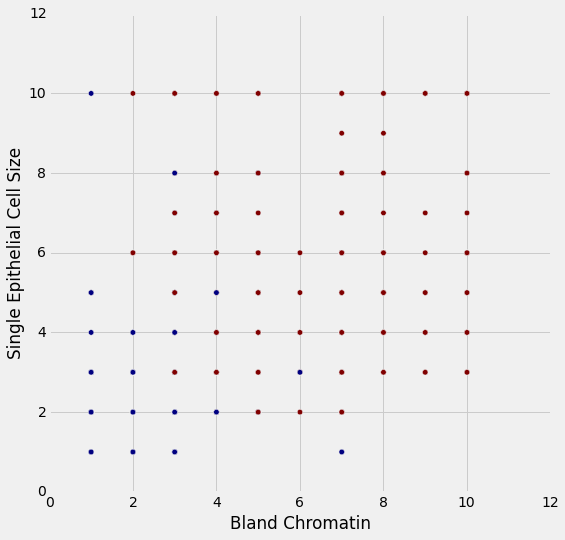

In [153]:
plots.figure(figsize=(8,8))
plots.scatter(patients['Bland Chromatin'], patients['Single Epithelial Cell Size'], c=patients['Class'], s=30)
plots.xlabel('Bland Chromatin')
plots.ylabel('Single Epithelial Cell Size')

Oops.  That plot is utterly misleading, because there are a bunch of points that have identical values for both the x- and y-coordinates.  To make it easier to see all the data points, I'm going to add a little bit of random jitter to the x- and y-values.  Here's how that looks:

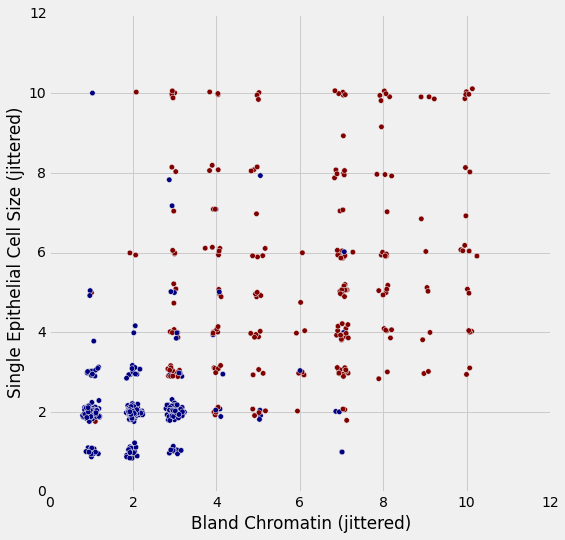

In [154]:
def randomize_column(a):
    return a + np.random.normal(0.0, 0.09, size=len(a))
plots.figure(figsize=(8,8))
plots.scatter(randomize_column(patients['Bland Chromatin']), randomize_column(patients['Single Epithelial Cell Size']), c=patients['Class'], s=30)
plots.xlabel('Bland Chromatin (jittered)')
plots.ylabel('Single Epithelial Cell Size (jittered)')

For instance, you can see there are lots of samples with chromatin = 2 and epithelial cell size = 2; all non-cancerous.

Keep in mind that the jittering is just for visualization purposes, to make it easier to get a feeling for the data.  When we want to work with the data, we'll use the original (unjittered) data.

### Applying the k-nearest neighbor classifier to breast cancer diagnosis

We've got a data set.  Let's try out the $k$-nearest neighbor classifier and see how it does.  This is going to be great.

We're going to need an implementation of the $k$-nearest neighbor classifier.  In practice you would probably use an existing library, but it's simple enough that I'm going to imeplment it myself.

The first thing we need is a way to compute the distance between two points.  How do we do this?  In 2-dimensional space, it's pretty easy.  If we have a point at coordinates $(x_0,y_0)$ and another at $(x_1,y_1)$, the distance between them is

$$D = \sqrt{(x_0-x_1)^2 + (y_0-y_1)^2}.$$

(Where did this come from?  It comes from the Pythogorean theorem: we have a right triangle with side lengths $x_0-x_1$ and $y_0-y_1$, and we want to find the length of the diagonal.)

In 3-dimensional space, the formula is

$$D = \sqrt{x_0-x_1)^2 + (y_0-y_1)^2 + (z_0-z_1)^2}.$$

In $k$-dimensional space, things are a bit harder to visualize, but I think you can see how the formula generalized: we sum up the squares of the differences between each individual coordinate, and then take the square root of that.  Let's implement a function to compute this distance function for us:

In [155]:
def distance(pt1, pt2):
    tot = 0
    for i in range(len(pt1)):
        tot = tot + (pt1[i] - pt2[i])**2
    return math.sqrt(tot)

Next, we're going to write some code to implement the classifier.  The input is a patient `p` who we want to diagnose.  The classifier works by finding the $k$ nearest neighbors of `p` from the training set.  So, our approach will go like this:

1. Find the closest $k$ neighbors of `p`, i.e., the $k$ patients from the training set that are most similar to `p`.

2. Look at the diagnoses of those $k$ neighbors, and take the majority vote to find the most-common diagnosis.  Use that as our predicted diagnosis for `p`.

So that will guide the structure of our Python code.

To implement the first step, we will compute the distance from each patient in the training set to `p`, sort them by distance, and take the $k$ closest patients in the training set.  The code will make a copy of the table, compute the distance from each patient to `p`, add a new column to the table with those distances, and then sort the table by distance and take the first $k$ rows.  That leads to the following Python code:

In [156]:
def closest(training, p, k):
    ...

def majority(topkclasses):
    ...

def classify(training, p, k):
    kclosest = closest(training, p, k)
    kclosest.classes = kclosest.select('Class')
    return majority(kclosest)

In [157]:
def computetablewithdists(training, p):
    dists = np.zeros(training.num_rows)
    attributes = training.drop('Class').rows
    for i in range(training.num_rows):
        dists[i] = distance(attributes[i], p)
    withdists = training.copy()
    withdists.append_column('Distance', dists)
    return withdists

def closest(training, p, k):
    withdists = computetablewithdists(training, p)
    sortedbydist = withdists.sort('Distance')
    topk = sortedbydist.take(range(k))
    return topk

def majority(topkclasses):
    if topkclasses.where('Class', 1).num_rows > topkclasses.where('Class', 0).num_rows:
        return 1
    else:
        return 0

def classify(training, p, k):
    closestk = closest(training, p, k)
    topkclasses = closestk.select('Class')
    return majority(topkclasses)

Let's see how this works, with our data set.  We'll take patient 12 and imagine we're going to try to diagnose them:

In [158]:
patients.take(12)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class
5,3,3,3,2,3,4,4,1,1


We can pull out just their attributes (excluding the class), like this:

In [159]:
patients.drop('Class').rows[12]

Row(Clump Thickness=5, Uniformity of Cell Size=3, Uniformity of Cell Shape=3, Marginal Adhesion=3, Single Epithelial Cell Size=2, Bare Nuclei=3, Bland Chromatin=4, Normal Nucleoli=4, Mitoses=1)

Let's take $k=5$.  We can find the 5 nearest neighbors:

In [160]:
closest(patients, patients.drop('Class').rows[12], 5)

Clump Thickness,Uniformity of Cell Size,Uniformity of Cell Shape,Marginal Adhesion,Single Epithelial Cell Size,Bare Nuclei,Bland Chromatin,Normal Nucleoli,Mitoses,Class,Distance
5,3,3,3,2,3,4,4,1,1,0
5,3,3,4,2,4,3,4,1,1,1.73205
5,1,3,3,2,2,2,3,1,0,3.16228
5,2,2,2,2,2,3,2,2,0,3.16228
5,3,3,1,3,3,3,3,3,1,3.31662


3 out of the 5 nearest neighbors have class 1, so the majority is 1 (has cancer) -- and that is the output of our classifier for this patient:

In [161]:
classify(patients, patients.drop('Class').rows[12], 5)

1

Awesome!  We now have a classification algorithm for diagnosing whether a patient has breast cancer or not, based on the measurements from the lab.  Are we done?  Shall we give this to doctors to use?

Hold on: we're not done yet.  There's an obvious question to answer, before we start using this in practice:

*How accurate is this method, at diagnosing breast cancer?*

And that raises a more fundamental issue.  How can we measure the accuracy of a classification algorithm?

### Measuring accuracy of a classifier

We've got a classifier, and we'd like to determine how accurate it will be.  How can we measure that?

**Try it out.**  One natural idea is to just try it on patients for a year, keep records on it, and see how accurate it is.  However, this has some disadvantages: (a) we're trying something on patients without knowing how accurate it is, which might be unethical; (b) we have to wait a year to find out whether our classifier is any good.  If it's not good enough and we get an idea for an improvement, we'll have to wait another year to find out whether our improvement was better.

**Get some more data.** We could try to get some more data from other patients whose diagnosis is known, and measure how accurate our classifier's predictions are on those additional patients.  We can compare what the classifier outputs against what we know to be true.

**Use the data we already have.** Another natural idea is to re-use the data we already have: we have a training set that we used to train our classifier, so we could just run our classifier on every patient in the data set and compare what it outputs to what we know to be true.  This is sometimes known as testing the classifier on your training set.

How should we choose among these options?  Are they all equally good?

It turns out that the third option, testing the classifier on our training set, is fundamentally flawed.  It might sound attractive, but it gives misleading results: it will over-estimate the accuracy of the classifier (it will make us think the classifier is more accurate than it really is).  Intuitively, the problem is that what we really want to know is how well the classifier has done at "generalizing" beyond the specific examples in the training set; but if we test it on patients from the training set, then we haven't learned anything about how well it would generalize to other patients.

This is subtle, so it might be helpful to try an example.  Let's try a thought experiment.  Let's focus on the 1-nearest neighbor classifier ($k=1$).  Suppose you trained the 1-nearest neighbor classifier on data from all 683 patients in the data set, and then you tested it on those same 683 patients.  How many would it get right?  Think it through and see if you can work out what will happen.  That's right!  The classifier will get the right answer for all 683 patients.  Suppose we apply the classifier to a patient from the training set, say Alice.  The classifier will look for the nearest neighbor (the most similar patient from the training set), and the nearest neighbor will turn out to be Alice herself (the distance from any point to itself is zero).  Thus, the classifier will produce the right diagnosis for Alice.  The same reasoning applies to every other patient in the training set.

So, if we test the 1-nearest neighbor classifier on the training set, the accuracy will always be 100%: absolutely perfect.  This is true no matter whether there are actually any patterns in the data.  But the 100% is a total lie.  When you apply the classifier to other patients who were not in the training set, the accuracy could be far worse.

In other words, testing on the training tells you nothing about how accurate the 1-nearest neighbor classifier will be.  This illustrates why testing on the training set is so flawed.  This flaw is pretty blatant when you use the 1-nearest neighbor classifier, but don't think that with some other classifier you'd be immune to this problem -- the problem is fundamental and applies no matter what classifier you use.  Testing on the training set gives you a biased estimate of the classifier's accurate.  For these reasons, you should never test on the training set.

So what *should* you do, instead?  Is there a more principled approach?

It turns out there is.  The approach comes down to: get more data.  More specifically, the right solution is to use one data set for training, and a different data set for testing, with no overlap between the two data sets.  We call these a *training set* and a *test set*.

Where do we get these two data sets from?  Typically, we'll start out with some data, e.g., the data set on 683 patients, and before we do anything else with it, we'll split it up into a training set and a test set.  We might put 50% of the data into the training set and the other 50% into the test set.  Basically, we are setting aside some data for later use, so we can use it to measure the accuracy of our classifier.  Sometimes people will call the data that you set aside for testing a *hold-out set*, and they'll call this strategy for estimating accuracy the *hold-out method*.

Note that this approach requires great discipline.  Before you start applying machine learning methods, you have to take some of your data and set it aside for testing.  You must avoid using the test set for developing your classifier: you shouldn't use it to help train your classifier or tweak its settings or for brainstorming ways to improve your classifier.  Instead, you should use it only once, at the very end, after you've finalized your classifier, when you want an unbiased estimate of its accuracy.

## The effectiveness of our classifier, for breast cancer

OK, so let's apply the hold-out method to evaluate the effectiveness of the $k$-nearest neighbor classifier for breast cancer diagnosis.  The data set has 683 patients, so we'll randomly permute the data set and put 342 of them in the training set and the remaining 341 in the test set.

In [162]:
patients = patients.sample(683) # Randomly permute the rows
trainset = patients.take(range(342))
testset  = patients.take(range(342, 683))

We'll train the classifier using the 342 patients in the training set, and evaluate how well it performs on the test set.  To make our lives easier, we'll write a function to evaluate a classifier on every patient in the test set:

In [163]:
def evaluate_accuracy(training, test, k):
    testattrs = test.drop('Class')
    numcorrect = 0
    for i in range(test.num_rows):
        # Run the classifier on the ith patient in the test set
        c = classify(training, testattrs.rows[i], k)
        # Was the classifier's prediction correct?
        if c == test['Class'][i]:
            numcorrect = numcorrect + 1
    return numcorrect / test.num_rows

Now for the grand reveal -- let's see how we did.  We'll arbitrarily use $k=5$.

In [164]:
evaluate_accuracy(trainset, testset, 5)

0.9706744868035191

About 96% accuracy.  Not bad!  Pretty darn good for such a simple technique.

As a footnote, you might have noticed that Brittany Wenger did even better.  What techniques did she use? One key innovation is that she incorporated a confidence score into her results: her algorithm had a way to determine when it was not able to make a confident prediction, and for those patients, it didn't even try to predict their diagnosis.  Her algorithm was 99% accurate on the patients where it made a prediction -- so that extension seemed to help quite a bit.

### Important takeaways

Here are a few lessons we want you to learn from this.

First, machine learning is powerful.  If you had to try to write code to make a diagnosis without knowing about machine learning, you might spend a lot of time by trial-and-error trying to come up with some complicated set of rules that seem to work, and the result might not be very accurate.  The $k$-nearest neighbors algorithm automates the entire task for you.  And machine learning often lets them make predictions far more accurately than anything you'd come up with by trial-and-error.

Second, you can do it.  Yes, you.  You can use machine learning in your own work to make predictions based on data.  You now know enough to start applying these ideas to new data sets and help others make useful predictions.  The techniques are very powerful, but you don't have to have a Ph.D. in statistics to use them.

Third, be careful about how to evaluate accuracy.  Use a hold-out set.

There's lots more one can say about machine learning: how to choose attributes, how to choose $k$ or other parameters, what other classification methods are available, how to solve more complex prediction tasks, and lots more.  In this course, we've barely even scratched the surface.  If you enjoyed this material, you might enjoy continuing your studies in statistics and computer science; courses like Stats 132 and 154 and CS 188 and 189 go into a lot more depth.